<h2> CNN for Music Genre Classification </h2>

In [44]:
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Define transformations
data_transform = transforms.Compose([
    transforms.Resize((216, 144)),  # Resize images to a standard size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet means and stds
])

Load the data

In [3]:
dataset = datasets.ImageFolder(root='./Data/images_original', transform=data_transform)

Split into train and validation sets

In [5]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Create dataloader instances

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [29]:
class MusicGenreCNN(nn.Module):
	def __init__(self):
		super(MusicGenreCNN, self).__init__()
		self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
		self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
		self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
		self.dropout = nn.Dropout(p=0.3)
		self.fc1 = nn.Linear(128 * 27 * 18, 512)
		self.fc2 = nn.Linear(512, 128)
		self.fc3 = nn.Linear(128, 10)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = self.pool(F.relu(self.conv3(x)))
		x = x.view(-1, 128 * 27 * 18)
		x = F.relu(self.fc1(x))
		x = self.dropout(x)
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return x

Define the model

In [30]:
# Initialize the model
model = MusicGenreCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the model

In [31]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    accuracy = correct / total
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch 1/20, Loss: 2.3997
Validation Loss: 2.2805, Accuracy: 0.1400
Epoch 2/20, Loss: 2.1359
Validation Loss: 2.0817, Accuracy: 0.1850
Epoch 3/20, Loss: 2.0371
Validation Loss: 2.0166, Accuracy: 0.2900
Epoch 4/20, Loss: 1.9274
Validation Loss: 1.8998, Accuracy: 0.3500
Epoch 5/20, Loss: 1.7836
Validation Loss: 1.8314, Accuracy: 0.3450
Epoch 6/20, Loss: 1.6842
Validation Loss: 1.7126, Accuracy: 0.4150
Epoch 7/20, Loss: 1.6069
Validation Loss: 1.5991, Accuracy: 0.4200
Epoch 8/20, Loss: 1.5144
Validation Loss: 1.5159, Accuracy: 0.4400
Epoch 9/20, Loss: 1.4255
Validation Loss: 1.4447, Accuracy: 0.5350
Epoch 10/20, Loss: 1.2794
Validation Loss: 1.4489, Accuracy: 0.4850
Epoch 11/20, Loss: 1.1743
Validation Loss: 1.2389, Accuracy: 0.6050
Epoch 12/20, Loss: 1.0450
Validation Loss: 1.3768, Accuracy: 0.5700
Epoch 13/20, Loss: 0.9091
Validation Loss: 1.4024, Accuracy: 0.5600
Epoch 14/20, Loss: 0.8283
Validation Loss: 1.3877, Accuracy: 0.6000
Epoch 15/20, Loss: 0.6873
Validation Loss: 1.2700, Accura

Evaluate model

              precision    recall  f1-score   support

       blues       0.80      0.47      0.59        17
   classical       0.87      0.95      0.91        21
     country       0.44      0.58      0.50        26
       disco       0.47      0.42      0.44        19
      hiphop       0.60      0.48      0.53        25
        jazz       0.64      0.86      0.73        21
       metal       0.71      0.71      0.71        14
         pop       0.69      0.52      0.59        21
      reggae       0.56      0.67      0.61        15
        rock       0.50      0.48      0.49        21

    accuracy                           0.61       200
   macro avg       0.63      0.61      0.61       200
weighted avg       0.62      0.61      0.61       200



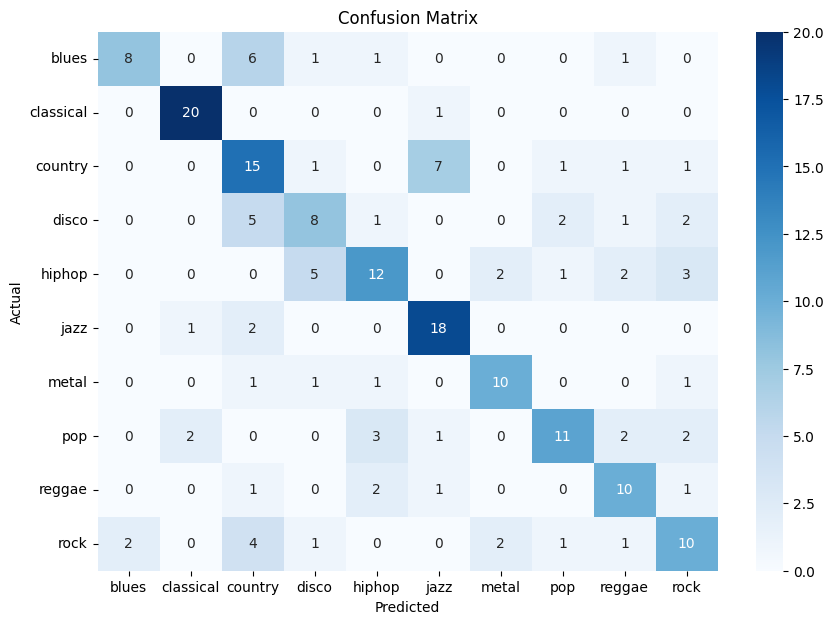

In [32]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Generate classification report
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Apply transfer learning on pre-trained model

In [ ]:
# Load pre-trained ResNet model
model_pretrained = models.resnet18(pretrained=True)

# Replace the last fully connected layer
num_ftrs = model_pretrained.fc.in_features
model_pretrained.fc = nn.Linear(num_ftrs, 10)  # 10 genres

# Transfer the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_pretrained = model_pretrained.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained.parameters(), lr=0.001, weight_decay=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 20
best_val_loss = float('inf')

for epoch in range(num_epochs):
	model_pretrained.train()
	running_loss = 0.0
	for images, labels in train_loader:
		images, labels = images.to(device), labels.to(device)
		optimizer.zero_grad()
		outputs = model_pretrained(images)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()
		running_loss += loss.item() * images.size(0)

	epoch_loss = running_loss / len(train_loader.dataset)
	print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

	# Validation
	model_pretrained.eval()
	val_loss = 0.0
	correct = 0
	total = 0
	with torch.no_grad():
		for images, labels in val_loader:
			images, labels = images.to(device), labels.to(device)
			outputs = model_pretrained(images)
			loss = criterion(outputs, labels)
			val_loss += loss.item() * images.size(0)
			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()

	val_loss = val_loss / len(val_loader.dataset)
	accuracy = correct / total
	print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

	if val_loss < best_val_loss:
		best_val_loss = val_loss
		# Check if model directory exists, if not create it
		if not os.path.exists('Best_DL_Models'):
			os.makedirs('Best_DL_Models')

		torch.save(model_pretrained.state_dict(), 'Best_DL_Models/model_pretrained.pth')

	scheduler.step()

c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Loss: 1.5994
Validation Loss: 2.9568, Accuracy: 0.3850
Epoch 2/20, Loss: 1.0479
Validation Loss: 1.2919, Accuracy: 0.5850
Epoch 3/20, Loss: 0.8089
Validation Loss: 3.6742, Accuracy: 0.3000
Epoch 4/20, Loss: 0.7146
Validation Loss: 6.7490, Accuracy: 0.1500
Epoch 5/20, Loss: 0.6024
Validation Loss: 4.8339, Accuracy: 0.2850
Epoch 6/20, Loss: 0.3450
Validation Loss: 1.9571, Accuracy: 0.5000
Epoch 7/20, Loss: 0.2676
Validation Loss: 4.7381, Accuracy: 0.3450
Epoch 8/20, Loss: 0.1773
Validation Loss: 0.7945, Accuracy: 0.8150
Epoch 9/20, Loss: 0.0719
Validation Loss: 0.7265, Accuracy: 0.7950
Epoch 10/20, Loss: 0.0376
Validation Loss: 0.7350, Accuracy: 0.8050
Epoch 11/20, Loss: 0.0241
Validation Loss: 0.7102, Accuracy: 0.7950
Epoch 12/20, Loss: 0.0244
Validation Loss: 0.7186, Accuracy: 0.7950
Epoch 13/20, Loss: 0.0177
Validation Loss: 0.7236, Accuracy: 0.8000
Epoch 14/20, Loss: 0.0172
Validation Loss: 0.7260, Accuracy: 0.8100
Epoch 15/20, Loss: 0.0212
Validation Loss: 0.7350, Accura

              precision    recall  f1-score   support

       blues       0.65      0.88      0.75        17
   classical       0.84      1.00      0.91        21
     country       0.77      0.65      0.71        26
       disco       0.67      0.84      0.74        19
      hiphop       0.95      0.76      0.84        25
        jazz       0.90      0.90      0.90        21
       metal       0.80      0.86      0.83        14
         pop       0.77      0.81      0.79        21
      reggae       0.86      0.80      0.83        15
        rock       0.79      0.52      0.63        21

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.81      0.80      0.79       200



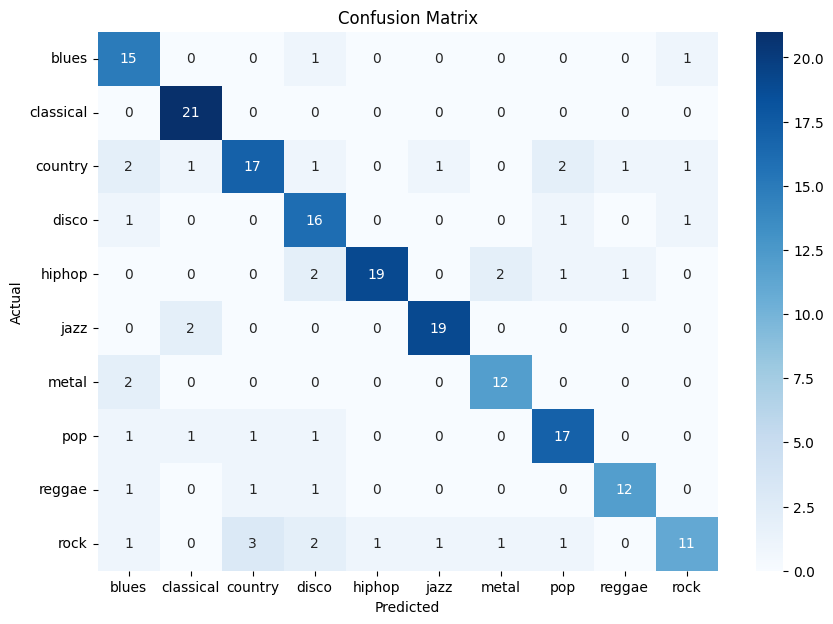

In [50]:
# Load and evaluate the best pre-trained model on the validation set
model_pretrained = models.resnet18()
num_ftrs = model_pretrained.fc.in_features
model_pretrained.fc = nn.Linear(num_ftrs, 10)
model_pretrained.load_state_dict(torch.load('Best_DL_Models/model_pretrained.pth'))
model_pretrained = model_pretrained.to(device)

model_pretrained.eval()
all_preds = []
all_labels = []

with torch.no_grad():
	for images, labels in val_loader:
		images, labels = images.to(device), labels.to(device)
		outputs = model_pretrained(images)
		_, predicted = torch.max(outputs, 1)
		all_preds.extend(predicted.cpu().numpy())
		all_labels.extend(labels.cpu().numpy())

# Generate classification report
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
